# Software Evolution - Practical Session
## Laws of software evolution based on code counting
## Academic year 2023-2024

### Write your answers under the questions that are present in this notebook  

#### Note: Print the final output of each cell in this notebook

#### Read the provided description document before proceeding with the following notebook

## 1.  Data preprocessing

To install packages, use :

pip install tqdm  pandas numpy matplotlib scikit-learn

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from permetrics.regression import RegressionMetric
from scipy.optimize import curve_fit
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from sklearn.model_selection import train_test_split

### Import dataset

First, import the dataset that contains the total lines of code, total blank lines, total comment lines, total number of files, and release date for each tag.

In [2]:
file_path = 'data/LawIncreasingGrowthDataset.csv'
df = pd.read_csv(file_path)
print(df)

        tag    code  blank  comment  nFiles release_date
0       1.4   48551   8727    11154     419   2009-01-06
1     1.5.0   63240  11018    18457     512   2009-02-18
2    jaunty   70751  11840    19671     578   2009-06-23
3     1.5.1   67939  11618    18131     600   2009-08-05
4     1.5.2   68564  11555    11906     611   2009-08-17
..      ...     ...    ...      ...     ...          ...
56    4.3.1  456159  72232   219480    3405   2016-12-14
57  4.3.1.1  456159  72232   219480    3405   2017-02-02
58    4.4.0  472926  75325   216544    3597   2017-03-07
59    4.4.1  473836  75392   216678    3598   2017-05-08
60    4.4.2  474213  75436   216751    3599   2017-08-30

[61 rows x 6 columns]


### Dataset A : Major.Minor.Patch tag format

Filter out non-official releases such as alpha, beta, release candidates, milestones, branches, and unnumbered tags. Additionally, version numbers typically follow a Major.Minor.Patch format, but exceptions exist (e.g., 1.4, 3.3.0.1, 4.3.0.1, or 4.3.1.1). Versions with more than three components are disregarded, and two-component versions are treated as implicit three-component versions (e.g., 1.4 is interpreted as 1.4.0).  

Write a regular expression statement to identify tags following semantic versioning (major.minor.patch) guidelines. You can use the pattern: '^v?[0-9]+\.[0-9]+(\.[0-9]+)?$'  

Once you've applied this regex, print out the selected major.minor.patch dataset.

In [3]:
version_pattern = r'^v?[0-9]+.[0-9]+(.[0-9]+)?$'

semantic_version_mask = df['tag'].str.match(version_pattern)
df = df[semantic_version_mask]

print(df)

      tag    code  blank  comment  nFiles release_date
0     1.4   48551   8727    11154     419   2009-01-06
1   1.5.0   63240  11018    18457     512   2009-02-18
3   1.5.1   67939  11618    18131     600   2009-08-05
4   1.5.2   68564  11555    11906     611   2009-08-17
6   1.6.1   86799  14582    41327     744   2009-11-05
9   2.0.0  115586  18488    42717    1074   2010-06-05
10  2.0.1  115699  18492    42724    1074   2010-07-06
21  3.0.0  188246  29836    60879    1694   2012-02-07
22  3.0.1  189022  29945    61587    1696   2012-03-12
26  3.1.0  191269  29973    62628    1642   2012-06-22
27  3.1.1  192026  30086    62931    1645   2012-09-17
28  3.1.2  192113  30101    62959    1646   2012-09-27
29  3.2.0  257934  43596   119688    2004   2012-12-17
33  3.2.1  260231  43992   120082    2011   2013-02-28
36  3.2.2  260173  43974   120045    2007   2013-04-16
38  3.3.0  350914  58798   159566    2682   2013-06-20
40  3.3.1  359678  60196   161364    2760   2013-09-11
41  3.3.2 

### Dataset B : Major.Minor tag format

Starting from the previous data (**Dataset A**),  for each Major.Minor.Patch tag group, select the earliest version (e.g., for a set of 4.4.0, 4.4.1, and 4.4.2, consider 4.4.0 and rename it to 4.4).

In [4]:
version_pattern2 = r'^v?(\d+\.\d+)(?:\.\d+)?$'
df['Major_Minor'] = df['tag'].str.extract(version_pattern2)
df['Major_Minor'] = df['Major_Minor'].astype(str)
earliest_versions = df.groupby('Major_Minor')['tag'].min()

first_occurrences = {}
for major_minor, earliest_version in earliest_versions.items():
    major_minor_df = df[df['Major_Minor'] == major_minor]
    first_occurrence = major_minor_df[major_minor_df['tag'] == earliest_version].iloc[0]
    first_occurrence['tag'] = major_minor
    first_occurrences[major_minor] = first_occurrence

df = pd.DataFrame(list(first_occurrences.values()))

df.drop(columns=['Major_Minor'], inplace=True)

print(df)

    tag    code  blank  comment  nFiles release_date
0   1.4   48551   8727    11154     419   2009-01-06
1   1.5   63240  11018    18457     512   2009-02-18
6   1.6   86799  14582    41327     744   2009-11-05
9   2.0  115586  18488    42717    1074   2010-06-05
21  3.0  188246  29836    60879    1694   2012-02-07
26  3.1  191269  29973    62628    1642   2012-06-22
29  3.2  257934  43596   119688    2004   2012-12-17
38  3.3  350914  58798   159566    2682   2013-06-20
42  3.4  291555  48371   149981    2367   2013-10-24
45  4.0  357375  57707   159944    2790   2014-05-30
48  4.1  419663  68854   208270    3283   2015-01-28
51  4.2  438240  71324   218459    3439   2015-10-22
54  4.3  455646  72172   219435    3405   2016-08-09
58  4.4  472926  75325   216544    3597   2017-03-07


## 2. Law of Increasing Growth

### Software project's metrics

Visualize four plots representing the evolution of a software project's metrics, including the number of lines of code, blank lines, comment lines, and the number of files, as follows:  

1. Plot the metrics against software version numbers:  
   1.1) For version tags of the format major.minor.patch.  
   1.2) For version tags of the format major.minor.  
   Place these plots at positions (0,0) and (0,1) respectively.  
  
2. Plot the metrics against dates:  
   2.1) For version tags of the format major.minor.patch.  
   2.2) For version tags of the format major.minor.  
   Place these plots right below the corresponding version-based plots, at positions (1,0) and (1,1).  

Hint: Ensure proper datetime formatting for the dates in the datasets instead of storing them as strings.

For example, if you're working with a DataFrame:

fig, axes = plt.subplots(2, 2, figsize=(18, 10))  
dataset_a[['code', 'blank', 'comment', 'nFiles', 'tag']].plot(x='tag', ax=axes[0, 0], legend=True)  
.....  

axes[0, 0].set_xlabel('Major.Minor.Patch versions')  
.....  

plt.tight_layout()  
plt.show()

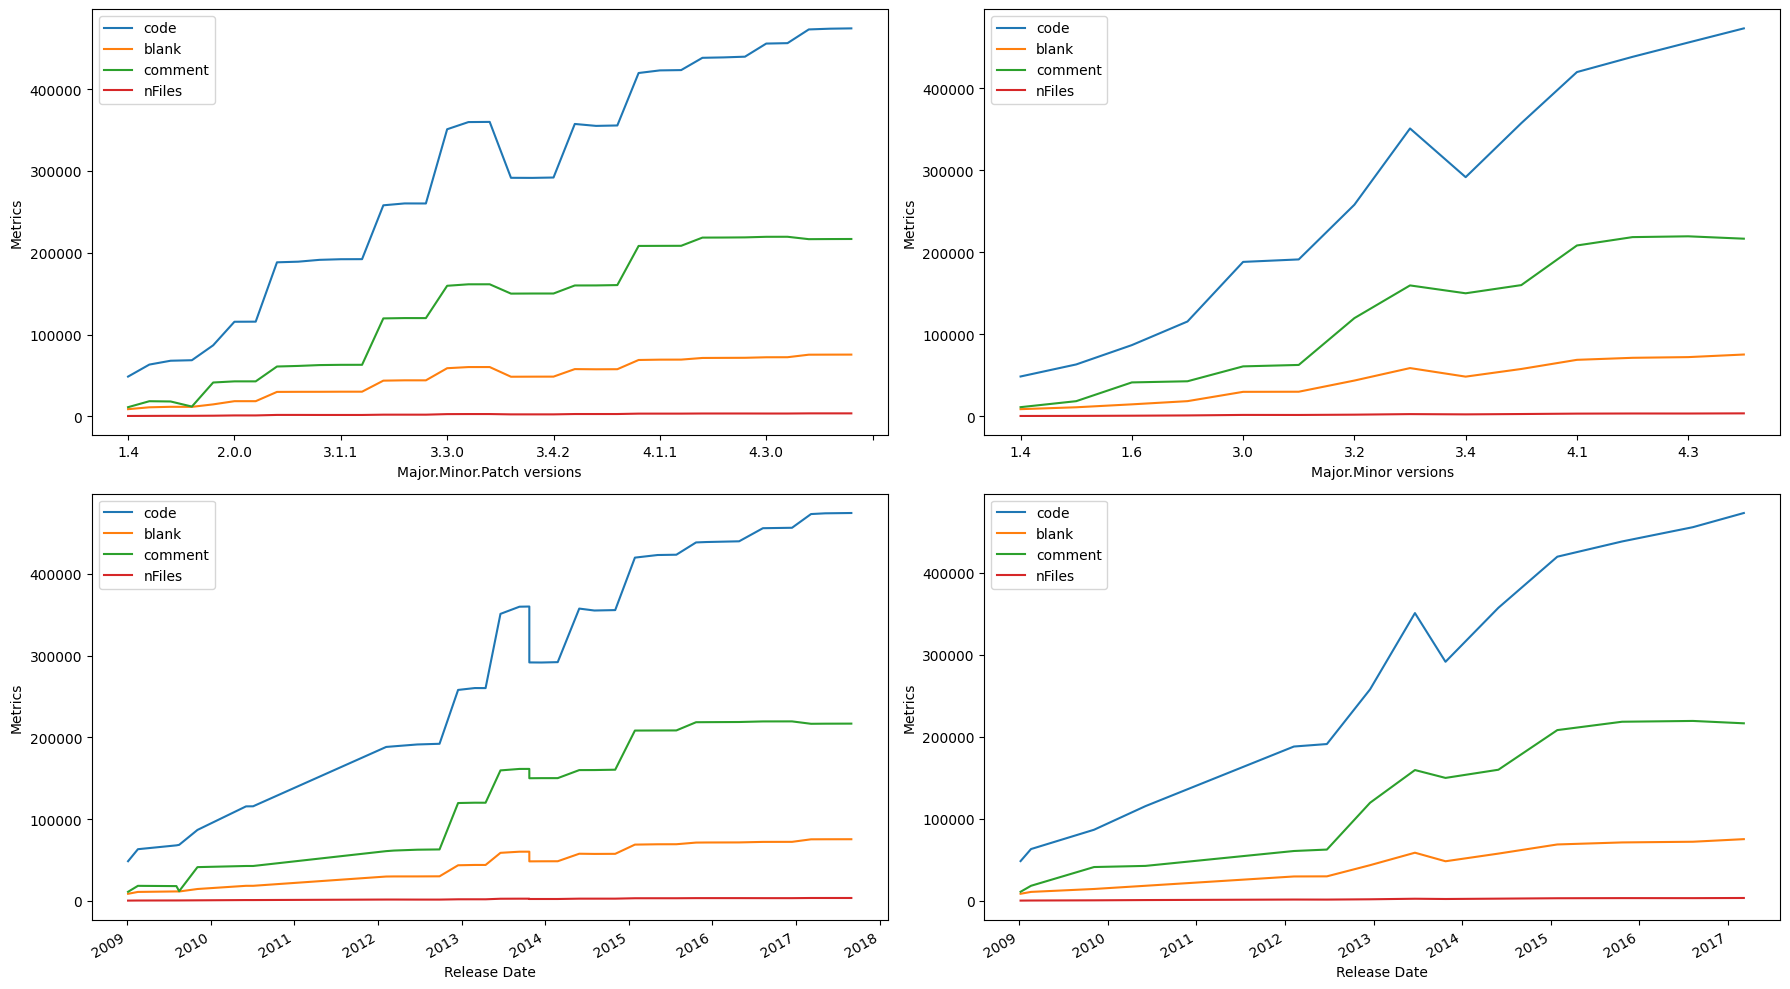

In [5]:
df = pd.read_csv(file_path)
version_pattern = r'^v?[0-9]+.[0-9]+(.[0-9]+)?$'

semantic_version_mask = df['tag'].str.match(version_pattern)
df = df[semantic_version_mask]
version_pattern2 = r'^v?(\d+\.\d+)(?:\.\d+)?$'

df['Major_Minor'] = df['tag'].str.extract(version_pattern2)

df['Major_Minor'] = df['Major_Minor'].astype(str)

df['release_date'] = pd.to_datetime(df['release_date'])

earliest_versions = df.groupby('Major_Minor').first()

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

df.plot(x='tag', y=['code', 'blank', 'comment', 'nFiles'], ax=axes[0, 0], legend=True)
axes[0, 0].set_xlabel('Major.Minor.Patch versions')
axes[0, 0].set_ylabel('Metrics')

earliest_versions.plot(y=['code', 'blank', 'comment', 'nFiles'], ax=axes[0, 1], legend=True)
axes[0, 1].set_xlabel('Major.Minor versions')
axes[0, 1].set_ylabel('Metrics')

df.plot(x='release_date', y=['code', 'blank', 'comment', 'nFiles'], ax=axes[1, 0], legend=True)
axes[1, 0].set_xlabel('Release Date')
axes[1, 0].set_ylabel('Metrics')

earliest_versions.plot(x='release_date', y=['code', 'blank', 'comment', 'nFiles'], ax=axes[1, 1], legend=True)
axes[1, 1].set_xlabel('Release Date')
axes[1, 1].set_ylabel('Metrics')

plt.tight_layout()
plt.show()

### Questions:

1. Do you find any difference between the plot that is having date in the x-axis and the plot that is having tag in the x-axis? If yes, then what is the difference? If no, then why is it same?

Yes, there is a difference. The release rate of patches/versions varies over time, it is not constant.

2. Which type of plot is preferable for software evolution analysis?   
    a) date in x-axis  
    b) tag in x-axis  
Why?

a) The system must continually evolve, and analyzing its evolution over time provides a better understanding of how the software grows.

### Correlation 

Correlation is generally used to analyse the relationship between variables. Here, analyse the relationship between the number of lines of code and the number of files using Spearman correlation and Pearson correlation by considering **Dataset A**. Report the correlation upto 3 decimal places.

In [9]:
file_path = 'data/LawIncreasingGrowthDatasetA.csv'
dfA = pd.read_csv(file_path)

lines_of_code = dfA['code']
num_files = dfA['nFiles']

spearman_corr, spearman_p_value = spearmanr(lines_of_code, num_files)

pearson_corr, pearson_p_value = pearsonr(lines_of_code, num_files)

print("Spearman Correlation:", round(spearman_corr, 3))
print("Pearson Correlation:", round(pearson_corr, 3))

Spearman Correlation: 0.986
Pearson Correlation: 0.998


### Questions:

3. Do you find any difference in correlation values between Pearson and Spearman? Which correlation measure is preferable for this use case? why?

The correlation values differ slightly but are still quite close. Pearson correlation coefficient is generally preferable if the data meets the assumptions of linearity. This is not the case here because a small change in the number of lines of code might correspond to a significant change in the number of files in one instance, while in another instance, it might not. So, I would choose the Spearman correlation coefficient.

4. Based on the above correlation value, please give your opinion on the relation between the number of lines and the number of files? Which of both size metrics do you propose to use in the remainder of your analysis?

Based on the above correlation value, there is strong positive relationship between the number of lines of code and the number of files. Being very close to each other, it is hard to make a decision but I would choose the number of files.

### Regression analysis

Visualize a linear regression analysis of the relationship between the release date and the total number of files by considering **Dataset B**.  

Hint:

1. Prepare the data: Convert the release date to integers and set number of files as the target variable.  
2. Apply linear regression analysis to understand the relationship between the release date and the total number of files.  
3. Calculate Mean Relative Error and ajusted R-squared metrics.    
4. Generate a scatter plot showing the release dates against the total number of files. Then, overlay the linear regression line on the plot.


Mean Relative Error: 0.06491034820337886
Adjusted R-squared: 0.9698878845416344


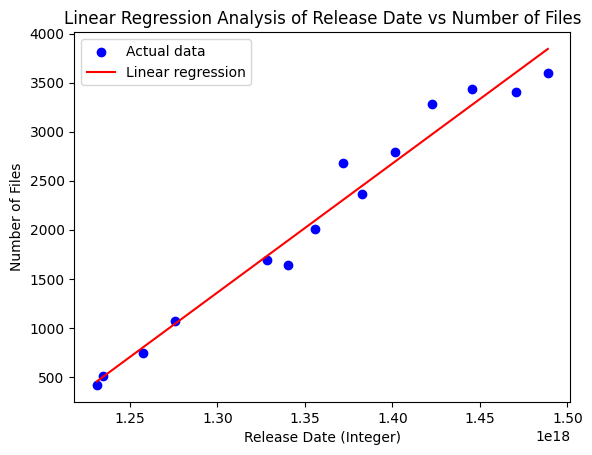

In [14]:
file_path = 'data/LawIncreasingGrowthDatasetB.csv'
dfB = pd.read_csv(file_path)

dfB['release_date'] = pd.to_datetime(dfB['release_date']).astype(np.int64)

x = dfB[['release_date']]
y = dfB['nFiles']

model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)

mean_relative_error = np.mean(np.abs((y - y_pred) / y))

n = len(y)
p = x.shape[1]
r_squared = r2_score(y, y_pred)
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

print("Mean Relative Error:", mean_relative_error)
print("Adjusted R-squared:", adjusted_r_squared)

plt.scatter(dfB['release_date'], y, color='blue', label='Actual data')
plt.plot(dfB['release_date'], y_pred, color='red', label='Linear regression')
plt.xlabel('Release Date (Integer)')
plt.ylabel('Number of Files')
plt.title('Linear Regression Analysis of Release Date vs Number of Files')
plt.legend()
plt.show()

### Questions:

5. Choose an option regarding the growth of the software. Motivate your choice using the 2D regression plot.  
    a) Linear  
    b) Sub-linear  
    c) Super-linear  

a) As the points in the 2D regression plot follow the linear regression line closely, it suggests that the growth of the software is linear.

6. Report the MRE and ajusted R-squared values.

Mean Relative Error: 0.06491034820337886
Adjusted R-squared: 0.9698878845416344

### Fitting & forecasting

Using **Dataset A**, apply parametric regression models (e.g., linear, exponential, power, quadratic, logarithmic) to predict the number of files in software releases based on historical data.

**Steps:**

1. Prepare Data:
   - Convert "release_date" to datetime format.
   - Calculate "release_days" as the number of days since the earliest release.

2. Split Data:
   - Separate data into features (release days) and target variable (number of files).
   - Split data into training and testing sets from the earliest release up to a specific point.

3. Build and Train Models:
   - Define regression models.
   - Fit models to training data (maybe using `curve_fit` from SciPy).

4. Forecast Future Data:
   - Predict the number of files for future release days using trained models.

5. Visualize Results:
   - Plot original data and forecasted values for each regression model.

6. Evaluate Models:
   - Calculate adjusted R-squared and mean relative error for each model using training and test data.

In [24]:
# Step 1: Prepare Data
file_path = 'data/LawIncreasingGrowthDatasetA.csv'
dfA = pd.read_csv(file_path)
dfA['release_date'] = pd.to_datetime(dfA['release_date'])
dfA['release_days'] = (dfA['release_date'] - dfA['release_date'].min()).dt.days

In [25]:
# Step 2: Split Data
X = dfA[['release_days']]
y = dfA['nFiles']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [26]:
# Step 3: Build and Train Models
def linear_model(x, a, b):
    return a * x + b

def power_model(x, a, b):
    return a * np.power(x, b)

def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c

models = {
    'Linear': linear_model,
    'Power': power_model,
    'Quadratic': quadratic_model
}

trained_models = {}
for name, model_func in models.items():
    popt, pcov = curve_fit(model_func, X_train['release_days'], y_train)
    trained_models[name] = {'parameters': popt, 'function': model_func}

In [27]:
# Step 4: Forecast Future Data
future_release_days = np.arange(X['release_days'].min(), X['release_days'].max() + 30, 30)
future_data = pd.DataFrame({'release_days': future_release_days})

forecasts = {}
for name, model in trained_models.items():
    forecasts[name] = model['function'](future_data['release_days'], *model['parameters'])

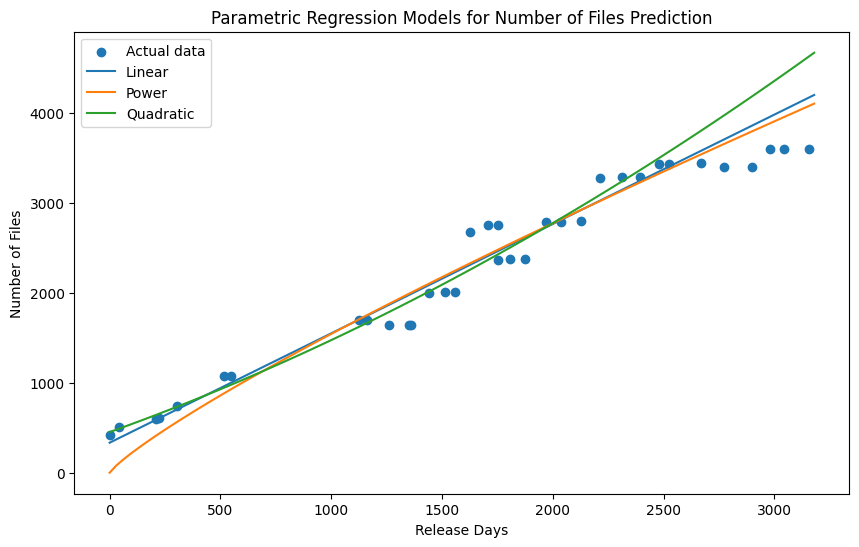

In [28]:
# Step 5: Visualize Results
plt.figure(figsize=(10, 6))
plt.scatter(X['release_days'], y, label='Actual data')
for name, forecast in forecasts.items():
    plt.plot(future_release_days, forecast, label=name)
plt.xlabel('Release Days')
plt.ylabel('Number of Files')
plt.title('Parametric Regression Models for Number of Files Prediction')
plt.legend()
plt.show()

In [29]:
# Step 6: Evaluate Models
evaluation = {}
for name, model in trained_models.items():
    y_train_pred = model['function'](X_train['release_days'], *model['parameters'])
    y_test_pred = model['function'](X_test['release_days'], *model['parameters'])
    train_r_squared = r2_score(y_train, y_train_pred)
    test_r_squared = r2_score(y_test, y_test_pred)
    train_mre = np.mean(np.abs((y_train - y_train_pred) / y_train))
    test_mre = np.mean(np.abs((y_test - y_test_pred) / y_test))
    evaluation[name] = {'Train R-squared': train_r_squared, 'Test R-squared': test_r_squared, 
                        'Train MRE': train_mre, 'Test MRE': test_mre}

print("Evaluation Metrics:")
for name, metrics in evaluation.items():
    print(name)
    print("Train R-squared:", metrics['Train R-squared'])
    print("Test R-squared:", metrics['Test R-squared'])
    print("Train MRE:", metrics['Train MRE'])
    print("Test MRE:", metrics['Test MRE'])
    print()

Evaluation Metrics:
Linear
Train R-squared: 0.9588146218202961
Test R-squared: -17.033066070562953
Train MRE: 0.08364831717824832
Test MRE: 0.09340687667504398

Power
Train R-squared: 0.938004438252449
Test R-squared: -11.487235568806927
Train MRE: 0.1661891737585228
Test MRE: 0.07829660276681284

Quadratic
Train R-squared: 0.9646703171137359
Test R-squared: -61.58051584744952
Train MRE: 0.06788052137945627
Test MRE: 0.1801414840437577



### Questions:

7. Which regression model do you prefer for assessing the goodness of fit, based on the evaluation metrics scores? Why?

I prefer the quadratic model because it has the lowest MRE and the highest R-squared value for the training set.

8. Which regression model do you prefer for assessing forecast accuracy, based on the evaluation metrics scores? Why?

I prefer the power model because it has the lowest MRE and the highest R-squared value for the test set, indicating better performance in predicting the number of files on unseen data compared to the other models.

### Modify the CLOC parameters

Exclude all bank lines and verify if the Law of Increasing Growth applies after this filtering

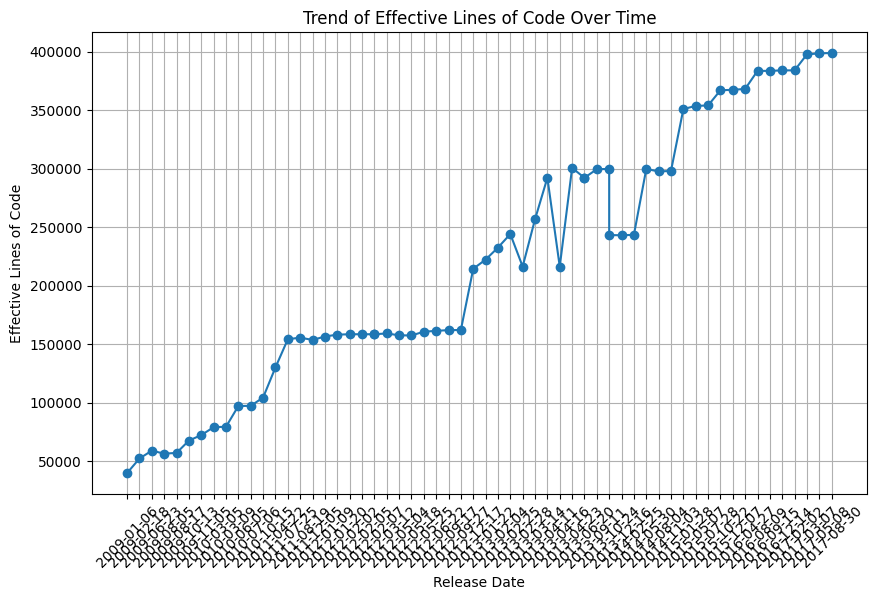

In [43]:
file_path = 'data/LawIncreasingGrowthDataset.csv'
df = pd.read_csv(file_path)

df['effective_code'] = df['code'] - df['blank']

df_filtered = df.drop(columns=['code', 'blank'])

df_filtered = df_filtered.sort_values(by='release_date')

plt.figure(figsize=(10, 6))
plt.plot(df_filtered['release_date'], df_filtered['effective_code'], marker='o', linestyle='-')
plt.xlabel('Release Date')
plt.ylabel('Effective Lines of Code')
plt.title('Trend of Effective Lines of Code Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Exclude all comment lines and verify if the Law of Increasing Growth applies after this filtering

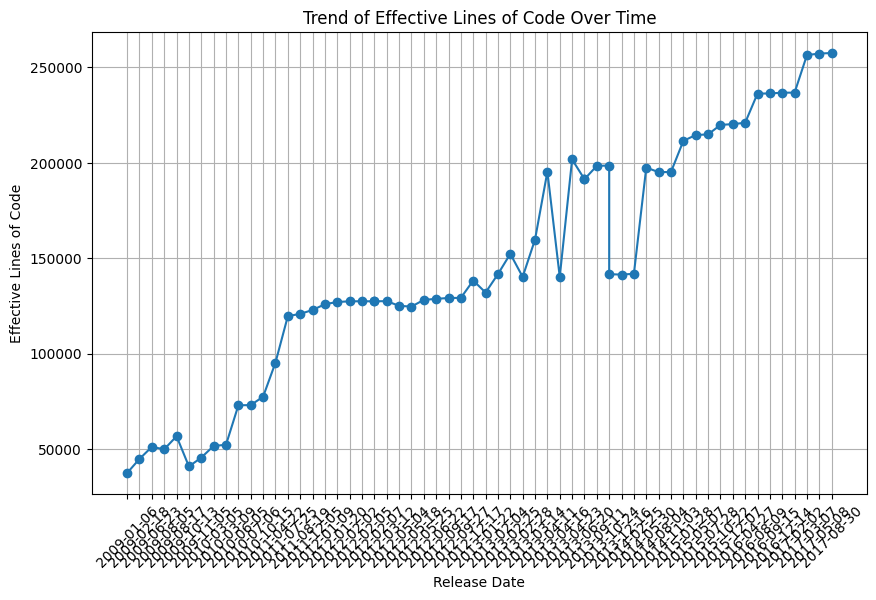

In [44]:
file_path = 'data/LawIncreasingGrowthDataset.csv'
df = pd.read_csv(file_path)

df['effective_code'] = df['code'] - df['comment']

df_filtered = df.drop(columns=['code', 'comment'])

df_filtered = df_filtered.sort_values(by='release_date')

plt.figure(figsize=(10, 6))
plt.plot(df_filtered['release_date'], df_filtered['effective_code'], marker='o', linestyle='-')
plt.xlabel('Release Date')
plt.ylabel('Effective Lines of Code')
plt.title('Trend of Effective Lines of Code Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## 3. Law of Continuing Change

### Dataset A : Major.Minor.Patch tag format

Import Dataset A that contains number of lines of code that are added, modified, removed and same between two consecutive tags for the three component versions (major.minor.patch)

In [46]:
file_path = 'data/LawContinuingChangeDatasetA.csv'
dfA = pd.read_csv(file_path)

Create a plot displaying all features together. Show the outcomes with dates on the x-axis and the corresponding numbers on the y-axis.

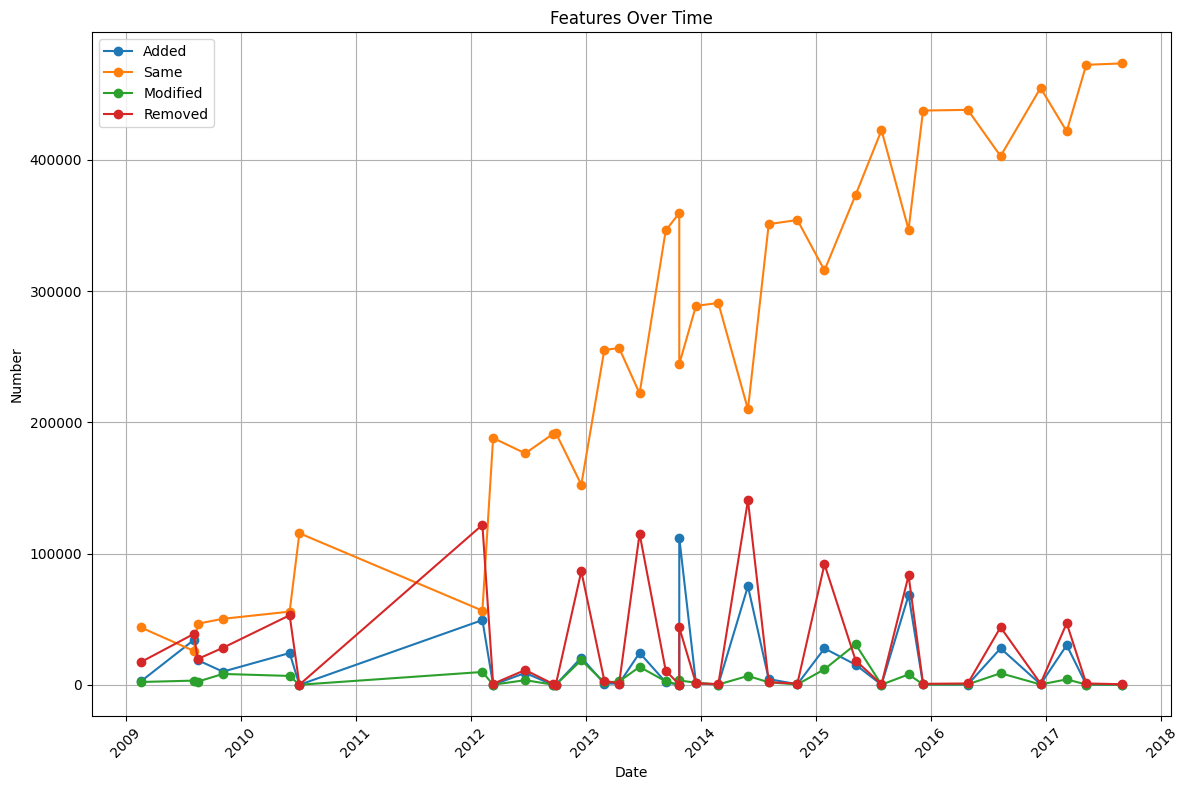

In [47]:
dfA['date'] = pd.to_datetime(dfA['date'])

plt.figure(figsize=(12, 8))

plt.plot(dfA['date'], dfA['added'], label='Added', marker='o')
plt.plot(dfA['date'], dfA['same'], label='Same', marker='o')
plt.plot(dfA['date'], dfA['modified'], label='Modified', marker='o')
plt.plot(dfA['date'], dfA['removed'], label='Removed', marker='o')

plt.xlabel('Date')
plt.ylabel('Number')
plt.title('Features Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Dataset B : Major.Minor tag format

Import Dataset B that contains number of lines of code that are added, modified, removed and same between two consecutive tags for the minor versions (major.minor)

In [48]:
file_path = 'data/LawContinuingChangeDatasetB.csv'
dfB = pd.read_csv(file_path)

Produce a plot where all features are represented together. Present the outcomes with dates on the x-axis and the corresponding numbers on the y-axis.

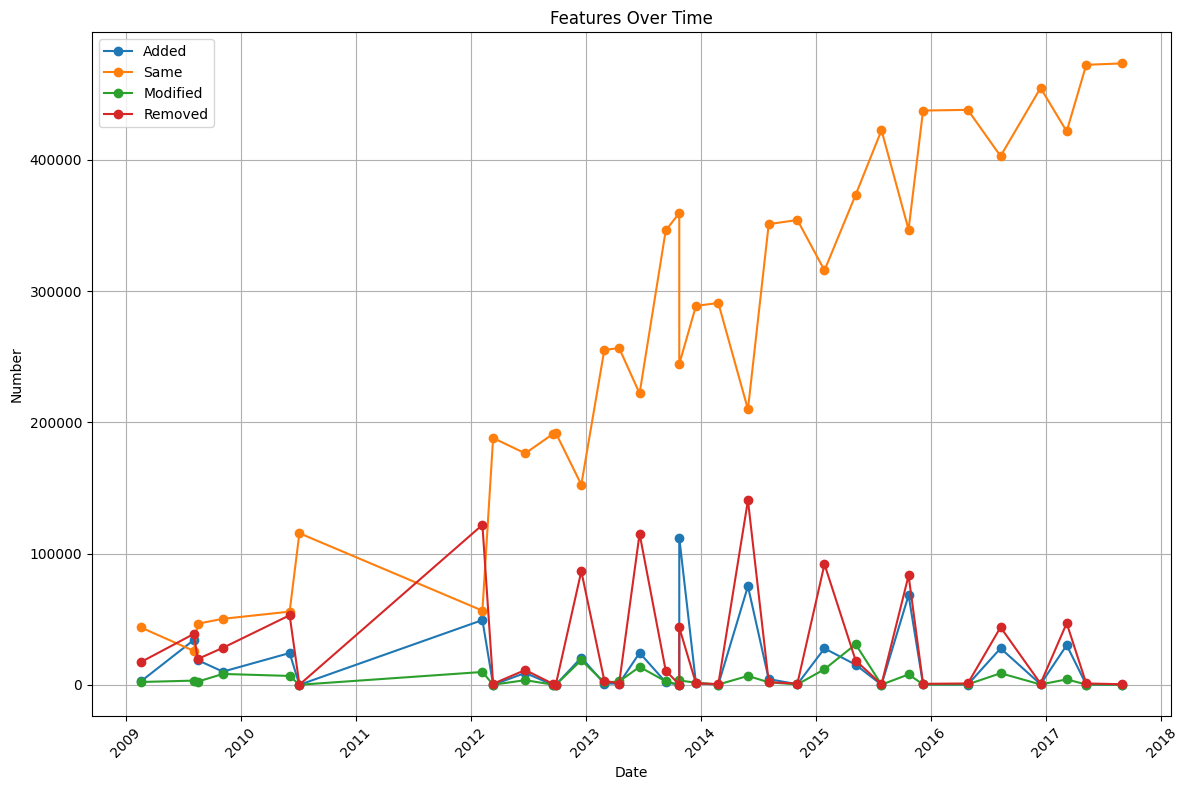

In [49]:
dfB['date'] = pd.to_datetime(dfB['date'])

plt.figure(figsize=(12, 8))

plt.plot(dfA['date'], dfA['added'], label='Added', marker='o')
plt.plot(dfA['date'], dfA['same'], label='Same', marker='o')
plt.plot(dfA['date'], dfA['modified'], label='Modified', marker='o')
plt.plot(dfA['date'], dfA['removed'], label='Removed', marker='o')

plt.xlabel('Date')
plt.ylabel('Number')
plt.title('Features Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Question:

1. Do you find empirical support for the Law of Continuing Change ? Motivate your response.

Yes, we can observe that the lines of code change and increase over time, except for the period from mid-2010 to 2012, during which no changes were made.